# A Cloud Price Comparison
How do cloud providers stack up?
 
Making apples to apples comparisons between different cloud providers is very difficult, because each one offers instances with varying vCPUs, RAM, SSD space and HDD space. To further obfuscate matters, slightly different billing systems, promises of arcane discounting, only providing pricing in USD, and inconsistent naming conventions are sprinkled throughout.

As an attempt to provide a clearer price comparison, I'll be using [multiple linear regression](https://en.wikipedia.org/wiki/Linear_regression) to "[normalise](http://bit.ly/2xIUM5C)" the pricing of compute instances across different cloud providers.

In essence, **If every cloud provider offered the same size compute instances, how expensive would they be?**

## Todo

* Account for GST

 ## Importing libraries

In [1]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import requests
import json
import re
from bs4 import BeautifulSoup
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The dataset

I'll be taking the price tables of:
* Google Cloud - [Predefined machine types](https://cloud.google.com/compute/pricing#predefined_machine_types)
* AWS - [On demand instances](https://aws.amazon.com/ec2/pricing/on-demand/)
* Azure - [Linux virtual machines](https://azure.microsoft.com/en-us/pricing/details/virtual-machines/linux/)

and converting them into the instance sizes offered by [Catalyst Cloud](https://www.catalyst.net.nz/catalyst-cloud/prices). You can find the datasets and their sources [here](https://github.com/catalyst-cloud/catalystcloud-price-comparison/raw/master/dataset/Cloud%20price%20comparison.ods).

In [2]:
# Initial variables

# List of existing dataset files
datasets = os.listdir('dataset')

# Refresh datasets?
fresh = False

### Exchange rate
Getting the USD to NZD exchange rate

In [3]:
usd_to_nzd_exchange_rate_url = 'http://free.currencyconverterapi.com/api/v5/convert?q=USD_NZD&compact=y'

usd_to_nzd_exchange_rate_json = requests.get(usd_to_nzd_exchange_rate_url).json()
usd_to_nzd_exchange_rate = float(usd_to_nzd_exchange_rate_json['USD_NZD']['val'])

### Catalyst Cloud prices
Scraping the Catalyst Cloud compute page for prices

In [4]:
# Variables

catalyst_url = 'https://catalystcloud.nz/services/iaas/compute'
catalyst_data_location = 'dataset/catalyst_price_data.csv'
catalyst_gst_exclusive = True

In [5]:
catalyst_price_page_html = requests.get(catalyst_url).text 
catalyst_price_page = BeautifulSoup(catalyst_price_page_html, 'html.parser')

catalyst_price_table = catalyst_price_page.find(attrs={'class': 'service-price-table'}).tbody
catalyst_price_rows = catalyst_price_table.find_all('tr')

catalyst_prices_list = []

for row in catalyst_price_rows:
    catalyst_price_cells = list(row.stripped_strings)
    catalyst_prices_list.append({
        'Name': catalyst_price_cells[0],
        'vCPU': float(catalyst_price_cells[1]),
        'RAM, GB': float(catalyst_price_cells[2]),
        'Price per hour, NZD (ex GST)': float(catalyst_price_cells[3].strip('$')),
        'SSD storage, GB': .0,
        'HDD storage, GB': .0
    })
    
pd.DataFrame(catalyst_prices_list).to_csv(catalyst_data_location)

### AWS prices

Scraping the AWS on demand pricing page for prices

In [6]:
# Variables

aws_url = 'https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/ap-southeast-2/index.json'
aws_raw_location = 'dataset/raw_aws_bulk.json'
aws_acceptable_instance_families = [
    'General purpose',
    'Memory optimized',
    'Micro instances'
]
aws_data_location = 'dataset/aws_price_data.csv'
aws_gst_exclusive = True

In [7]:
if aws_raw_location.split('/')[1] not in datasets or fresh:
    aws_bulk_json_request = requests.get(aws_url)
    aws_bulk_json = aws_bulk_json_request.json()
    with open(aws_raw_location, 'w') as aws_raw_file:
        json.dump(aws_bulk_json, aws_raw_file)
    print('Downloaded most recent AWS price list.')
else:
    print('AWS raw dataset already dowloaded.')

AWS raw dataset already dowloaded.


Extracting the specific relevant prices from the raw AWS file, and putting them in a consistant, usable format.

In [8]:
# Getting the instance products

with open(aws_raw_location, 'r') as aws_raw_file:
    aws_raw_json = json.load(aws_raw_file)
        
    aws_instances_list = []
            
    for product in aws_raw_json['products']:
        
        productFamily = aws_raw_json['products'][product]['productFamily']
        
        # Check product is compute instance
        if productFamily == 'Compute Instance':
                        
            # Check if instance is appropriate
            instanceFamily = aws_raw_json['products'][product]['attributes']['instanceFamily']
            is_current_gen = aws_raw_json['products'][product]['attributes']['currentGeneration'] == 'Yes'
            is_linux = aws_raw_json['products'][product]['attributes']['operatingSystem'] == 'Linux'
            no_preInstalledSw = aws_raw_json['products'][product]['attributes']['preInstalledSw'] == 'NA'
            is_shared_instance = aws_raw_json['products'][product]['attributes']['tenancy'] == 'Shared'

            if instanceFamily in aws_acceptable_instance_families and is_current_gen \
                and is_linux and no_preInstalledSw and is_shared_instance:
                
                # Append if appropriate
                aws_instances_list.append(product)

In [9]:
with open(aws_raw_location, 'r') as aws_raw_file:
    
    aws_prices_list = []
    
    for instance_key in aws_instances_list:

        attributes = aws_raw_json['products'][instance_key]['attributes']
                    
        # Get vCPU and RAM
        vCPU = float(attributes['vcpu'].replace(',',''))
        RAM = float(attributes['memory'].split(' ')[0].replace(',',''))

        # Break storage spec into array
        storage_strings = attributes['storage'].split(' ')

        # Find where the numbers end (200 x 1), and the description of the storage type (SSD) starts.
        final_num_index = None
        for word in storage_strings[::-1]:
            try:
                float(word.replace(',', ''))
                final_num_index = storage_strings.index(word)
                break
            except:
                foo = None

        # If there are no numbers in the storage spec, there is no storage included
        if final_num_index == None:

            total_ssd = .0
            total_hdd = .0

        # Else...
        else:

            # Perform the math to figure out how many GB of storage is included
            storage_calcs = storage_strings[0:final_num_index+1]
            storage_volume = eval(' '.join(['*' if x=='x' else x.replace(',', '') for x in storage_calcs]))

            # discern the type of storage
            if 'HDD' in storage_strings:                        
                total_ssd = .0
                total_hdd = float(storage_volume)

            elif 'SSD' in storage_strings:                        
                total_ssd = float(storage_volume)
                total_hdd = .0
            else: 
                total_ssd = float(storage_volume)
                total_hdd = .0


        # Get the price per USD
        terms = aws_raw_json['terms']['OnDemand'][instance_key]
        usd_price = None
        for specific_term in terms:
            for dimension_key in terms[specific_term]['priceDimensions']:
                dimension = terms[specific_term]['priceDimensions'][dimension_key]
                if dimension['unit'] != 'Hrs': raise ValueError("This price isn't in hours")
                usd_price = float(dimension['pricePerUnit']['USD'])

        # Convert to NZD
        nzd_price = usd_price * usd_to_nzd_exchange_rate
                
        # Append to list of prices
        aws_prices_list.append({
            'Name': attributes['instanceType'],
            'vCPU': vCPU,
            'RAM, GB': RAM,
            'Price per hour, NZD (ex GST)': nzd_price,
            'SSD storage, GB': total_ssd,
            'HDD storage, GB': total_hdd
        })

# Convert to CSV
pd.DataFrame(aws_prices_list).to_csv(aws_data_location)

### Google Cloud prices

Scraping Google Cloud's documentation for prices of custom instance sizes.

In [10]:
# Variables

google_url = 'https://cloud.google.com/compute/pricing'
google_price_type = 'syd-hourly'
google_acceptable_instance_families = [
    'standard_machine_types',
    'high-memory_machine_types',
    'high-cpu_machine_types'
]
google_data_location = 'dataset/google_price_data.csv'
google_gst_exclusive = True

In [11]:
google_price_page_html = requests.get(google_url).text
google_price_page = BeautifulSoup(google_price_page_html, 'html.parser')

In [12]:
# Extract the USD price per vCPU and per GB RAM
google_custom_compute_price_table = google_price_page.find(id='custommachinetypepricing').find_next('table')
google_custom_compute_rows = google_custom_compute_price_table.find_all('tr')[1:]

google_per_vcpu_usd = float(google_custom_compute_rows[0].find_all('td')[1][google_price_type].split()[0].strip('$'))
google_per_ram_usd = float(google_custom_compute_rows[1].find_all('td')[1][google_price_type].split()[0].strip('$'))

In [13]:
def most_freq_num(text):
    number_list = re.findall('\d*\.?\d+', text)
    most_frequent_num = max(set(number_list), key=number_list.count)
    return float(most_frequent_num)

In [14]:

google_prices_list = []

for instance_type in google_acceptable_instance_families:
    
    google_price_table = google_price_page.find(id=instance_type).find_next('table')
    google_rows = google_price_table.find_all('tr')[1:-1]
        
    for row in google_rows:
        
        # Extract number of vCPUs and GB of RAM
        try:
            cells = row.find_all('td')
            name = cells[0].get_text().strip()
            # Ignore if has lake in name (to remove skylake instances)
            if 'lake' in name:
                continue
            cpu_val = most_freq_num(str(cells[1]))
            ram_val = most_freq_num(str(cells[2]))
        except:
            foo='bar'
                        
        # Calcluate NZD price
        usd_price = (google_per_ram_usd * ram_val) + (google_per_vcpu_usd * cpu_val)
        nzd_price = usd_price * usd_to_nzd_exchange_rate
        
        try:
            google_prices_list.append({
                'Name': name,
                'vCPU': cpu_val,
                'RAM, GB': ram_val,
                'Price per hour, NZD (ex GST)': usd_price,
                'SSD storage, GB': .0,
                'HDD storage, GB': .0
            })
        except:
            continue

pd.DataFrame(google_prices_list).to_csv(google_data_location)

### Azure cloud prices
Get Azure pricing from community maintained price list. This is because it is too difficult to scrape the Azure pricing page, and they maintain no APIs.

In [15]:
# Variables
azure_url = 'https://azure.microsoft.com/en-us/pricing/details/virtual-machines/linux/'
azure_data_location = 'dataset/azure_price_data.csv'
azure_acceptable_instance_families = [
    'b-series',
    'a-series',
    'd-series',
    'e-series'
]
azure_acceptable_regions = [
    'australia-central',
    'australia-central-2',
    'australia-east',
    'australia-southeast'
]
azure_ssd_temp_disk_vms = [
    r'A\d.v2', # Regex for Av2-series
    r'D\d{1,2}.v2', # Regex for Dv2 series
    r'D\d{1,2}.v3', # Regex for Dv3 series
    r'E\d{1,2}.v3' # Regex for Ev3 series
] 
azure_gst_exclusive = True

In [16]:
azure_price_page_html = requests.get(azure_url).text
azure_price_page = BeautifulSoup(azure_price_page_html, 'html.parser')

In [17]:
# Find all appropriate price tables
appropriate_price_tables = []
for family_id in azure_acceptable_instance_families:
    price_table_titles = azure_price_page.find_all(id=family_id)
    appropriate_price_tables += [x.find_next('table', class_='sd-table') for x in price_table_titles]
            
# Extract data from tables
azure_instance_list = []
for price_table in appropriate_price_tables:
    table_rows = price_table.tbody.find_all('tr')
        
    # Work through each row
    for row in table_rows:
        
        cells = row.find_all('td')
        
        # Find a price by checking if each of the acceptable regions have a price
        usd_price = None
        price_json = json.loads(cells[5].span['data-amount'])['regional']
        for region in azure_acceptable_regions:
            if region in price_json:
                usd_price = price_json[region]
                break
                
        # If none of the regions have it, skip this row
        if usd_price is None:
            continue
        
        # Get NZD price
        nzd_price = usd_price * usd_to_nzd_exchange_rate
        
        # Get name
        name = cells[1].string
        
        cpu_val = float(cells[2].string)
        
        ram_string = cells[3].string
        ram_string = ram_string.strip(' GiB')
        ram_val = float(ram_string)
        
        storage_string = cells[4].string
        storage_string = storage_string.strip(' GiB')
        storage_string = storage_string.replace(',', '')
        storage_val = float(storage_string)
        
        for regex_string in azure_ssd_temp_disk_vms:
            pattern = re.compile(regex_string)
            if pattern.match(name):
                storage_type = 'SSD'
            else:
                storage_type = 'HDD'
                
        
        if storage_type is 'HDD':
            azure_instance_list.append({
                'Name': name,
                'vCPU': cpu_val,
                'RAM, GB': ram_val,
                'Price per hour, NZD (ex GST)': usd_price,
                'SSD storage, GB': .0,
                'HDD storage, GB': storage_val
            })
        elif storage_type is 'SSD':
            azure_instance_list.append({
                'Name': name,
                'vCPU': cpu_val,
                'RAM, GB': ram_val,
                'Price per hour, NZD (ex GST)': usd_price,
                'SSD storage, GB': storage_val,
                'HDD storage, GB': .0
            })
        else:
            raise ValueError('Unknown storage type.')

pd.DataFrame(azure_instance_list).to_csv(azure_data_location)

### Ingesting the datasets
Importing the datasets.

In [18]:
catalyst_dataset = pd.read_csv(catalyst_data_location, index_col=0)
google_dataset = pd.read_csv(google_data_location, index_col=0)
aws_dataset = pd.read_csv(aws_data_location, index_col=0)
azure_dataset = pd.read_csv(azure_data_location, index_col=0)

Previewing the datasets.

In [19]:
catalyst_dataset.head(6)

,"HDD storage, GB",Name,"Price per hour, NZD (ex GST)","RAM, GB","SSD storage, GB",vCPU
0,0.0,c1.c1.r05,0.030,0.5,0.0,1.0
1,0.0,c1.c1r1,0.044,1.0,0.0,1.0
2,0.0,c1.c1r2,0.062,2.0,0.0,1.0
3,0.0,c1.c1r4,0.098,4.0,0.0,1.0
4,0.0,c1.c2r1,0.070,1.0,0.0,2.0
5,0.0,c1.c2r2,0.088,2.0,0.0,2.0


Now we'll split the data into NumPy arrays of input features (X) and labels (Y).

In [20]:
def split_dataset (dataset):
    x = dataset[["vCPU", "RAM, GB", "HDD storage, GB", "SSD storage, GB"]].values
    y = dataset["Price per hour, NZD (ex GST)"].values
    
    return (x, y)

In [21]:
catalyst_x, catalyst_y = split_dataset(catalyst_dataset)
google_x, google_y = split_dataset(google_dataset)
aws_x, aws_y = split_dataset(aws_dataset)
azure_x, azure_y = split_dataset(azure_dataset)

## The math
To analyse this dataset, we'll be using [multiple linear regression](https://en.wikipedia.org/wiki/Linear_regression) to predict the prices of compute instance flavors if they were being offered by cloud providers that do not typically offer that sized flavor.

The multiple linear regression models will draw a hyperplane across our data space (in this case, 5 dimensional space) that comes as close as possible to intersecting every data point in our dataset. You can see an example of this (in 2 dimensional space) by Khan academy below.

In [22]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="840" height="472" src="https://www.youtube-nocookie.com/embed/GAmzwIkGFgE?rel=0" frameborder="0" allowfullscreen></iframe>'))

By then finding a point on the hyperplane that intersects with our vCPUs, RAM, HDD, and SSD axes, we can find the predicted price. This will give us a way to estimate the price of a flavour if it were offered by various cloud providers, even if they do not offer it.

I've used linear regression as the predictive algorithm because I'm assuming that cloud providers scale their pricing in a linear patern. For example, Catalyst Cloud decides the price of their flavors with the equation: 

Price/hour = (RAM gb x 0.18) + (vCPU x 0.026)

First we'll initialise the regression models, and train them on the cloud providers' prices.

In [23]:
# Initialise regressors
catalyst_linear = LinearRegression()
google_linear = LinearRegression()
aws_linear = LinearRegression()
azure_linear = LinearRegression()

# Train regressors
catalyst_linear.fit(catalyst_x, catalyst_y)
google_linear.fit(google_x, google_y)
aws_linear.fit(aws_x, aws_y)
azure_linear.fit(azure_x, azure_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we have the models predict the other providers' instance prices. By having all providers predict the prices of all other providers, we can see if the pattern is maintained across different models.

In [24]:
# Predict Catalyst X
google_cata_price = google_linear.predict(catalyst_x)
aws_cata_price = aws_linear.predict(catalyst_x)
azure_cata_price = azure_linear.predict(catalyst_x)

# Predict Google X
aws_goog_price = aws_linear.predict(google_x)
azure_goog_price = azure_linear.predict(google_x)
catalyst_goog_price = catalyst_linear.predict(google_x)

# Predict AWS X
google_aws_price = google_linear.predict(aws_x)
azure_aws_price = azure_linear.predict(aws_x)
catalyst_aws_price = catalyst_linear.predict(aws_x)

# Predict Azure X
google_azure_price = google_linear.predict(azure_x)
aws_azure_price = aws_linear.predict(azure_x)
catalyst_azure_price = catalyst_linear.predict(azure_x)

## The results

Now we have the results together, where we can compare the prices against each other on an even scale.

A good scientist would, at this point, verify their results by comparing an intersection between the predicted output and the actual output. I would love to do this. However I could find no such intersection.

You can find the datasets this analysis is based on [here](https://github.com/catalyst-cloud/catalystcloud-price-comparison/raw/master/dataset/Cloud%20price%20comparison.ods), and a chart plotting this data, [here](https://object-storage.nz-por-1.catalystcloud.io/v1/AUTH_8ccc3286887e49cb9a40f023eba693b4/catalyst-cloud-price-comp/).

Please note that the X axis is a range from zero to the number of flavors offered by each provider. Each number on the X axis represents a single flavor by the provider we are predicting. I've done it this way because the plotting method does not support non-numerical axis ticks.

In [25]:
def graph_pred (names, predictions):
    flavors_num = predictions[0].shape[0]
    for index, name in enumerate(names):
        plt.plot(range(flavors_num), predictions[index], label=names[index])
    plt.legend(loc=2)

### Predicting Catalyst Cloud

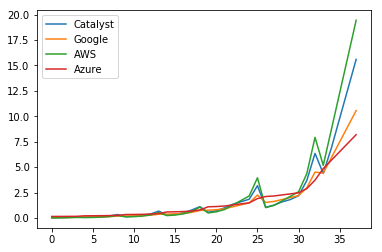

In [26]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_y, google_cata_price, aws_cata_price, azure_cata_price
    ])

### Predicting Google Cloud

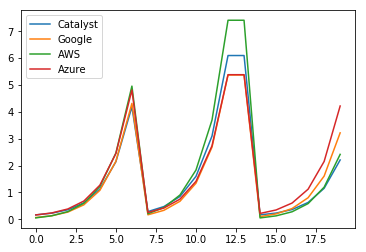

In [27]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_goog_price,
        google_y,
        aws_goog_price,
        azure_goog_price,
        
    ])

### Predicting AWS

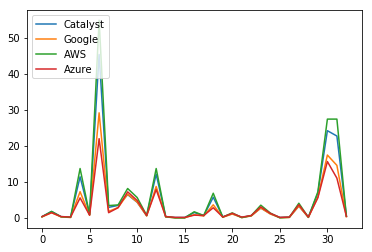

In [28]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_aws_price,
        google_aws_price,
        aws_y,
        azure_aws_price,
    ])

### Predicting Azure

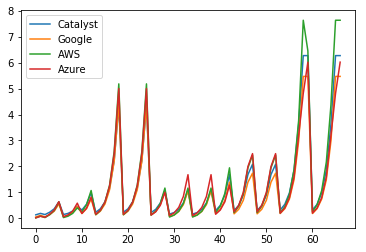

In [29]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_azure_price,
        google_azure_price,
        aws_azure_price,
        azure_y
    ])

### Interpreting the results

As you can see, the multiple linear regression model consistently predicts that Catalyst Cloud would offer either the cheapest, or competitively priced compute instances.

While this is by no means a perfect indicator of who is the cheapest and should not be taken as such, it does serve to dispel the idea that Catalyst Cloud is overpriced, or cannot compete with international companies on price.

### Saving the results
For further analysis later, we'll save the predicted prices as CSVs.

In [30]:
def pred_save (origin_flavors, provider_names, predictions):
    
    flavor_data = origin_flavors[["Name", "vCPU", "RAM, GB", "HDD storage, GB", "SSD storage, GB"]]
    
    print(type(origin_flavors))
    
    for index, provider in enumerate(predictions):
        unit_string = ' price per hour, NZD (ex GST)'
        company_name = provider_names[index]
        flavor_data[company_name + unit_string] = predictions[index]
    
    return flavor_data

In [31]:
final_cat_data = pred_save(
    catalyst_dataset,
    [
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_y, google_cata_price, aws_cata_price, azure_cata_price
    ])

<class 'pandas.core.frame.DataFrame'>


In [32]:
final_google_data = pred_save(
    google_dataset,
    [
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_goog_price,
        google_y,
        aws_goog_price,
        azure_goog_price,
        
    ])

<class 'pandas.core.frame.DataFrame'>


In [33]:
final_aws_data = pred_save(
    aws_dataset,
    [
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_aws_price,
        google_aws_price,
        aws_y,
        azure_aws_price,
    ])

<class 'pandas.core.frame.DataFrame'>


In [34]:
final_azure_data = pred_save(
    azure_dataset,
    [
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_azure_price,
        google_azure_price,
        aws_azure_price,
        azure_y
    ])

<class 'pandas.core.frame.DataFrame'>


In [35]:
final_cat_data.to_csv('predicted-dataset/predicted_catalyst_prices.csv')
final_google_data.to_csv('predicted-dataset/predicted_google_prices.csv')
final_aws_data.to_csv('predicted-dataset/predicted_aws_prices.csv')
final_azure_data.to_csv('predicted-dataset/predicted_azure_prices.csv')